# Introduction

This codebook include the writeup as well as the computations for the CS146 assignment: Posterior predictive check.

The assignment will evaluate how well the non-hierarchical model explains the observed data from the control groups in he medical trial dataset. It will do so by comparing the test statistics from the replicated data generated from the model with the actual observed data. If the model is a good fit to the data, then it will with a high accuracy replicate the observed characteristics of the dataset.

For the non-hierarchical model, every trail has the same probability of success - Refered later to successrate. The number of successes for each trail comes from a binomal distribution with the same probability of success, however, differing in group size. The model assumes that the observed data is a sample from this model.

The posterior distribution of the successrate from the non-hierarchical model is a beta distribution with alpha = 58 and beta = 65.

To mitigate the influence from the differing group sizes, the test statistics will be used on the actual successfractions (Fraction of improvement) for the trails in each dataset. The choosen test statistics are:

*  Mean successfraction - Indicate whether our model explain the average observed successfraction
*  Variance successfraction - Indicate whether our model captures the variance in successfraction for the trails
*  Minimum successfraction - Indicate whether our model explain any extremly low successfraction
*  Maximum successfraction - Indicate whether our model explain any extremly high successfraction
*  Range of successfraction - Indicate whether our model explains the range in observed successfraction


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [2]:
def model_1(prior_alpha, prior_beta, data):
    """This function computes the posterior beta distribution from which the probability of success is drawn from"""
    
    post_alpha = prior_alpha + np.sum(data[:, 0]) #posterior alpha
    post_beta = prior_alpha + np.sum(data[:, 1]) - np.sum(data[:, 0]) #posterior beta
    
    post_dist_p = sts.beta(a = post_alpha, b = post_beta) #posterior distribution
    
    return post_dist_p

def test_stats(data_matrix):
    """This function computes the 1st, 2nd, 3rd, 4th, and 5th test statistic.
    
    The 1st test statistic is defined as the mean of the successfraction
    The 2st test statistic is defined as the variance of the successfraction
    The 3st test statistic is defined as the minimum successfraction for improvement
    The 4rd test statstic is defined as the maximum successfraction for improvement
    The 5nd test statistic is defined as the range of successfraction for improvement
"""
    
    #divide the first element (#success) in the row with the second element in the row (#trails)
    success_rates = np.divide(data_matrix[:,0], data_matrix[:,1])
    
    #test_statistics
    mean = np.mean(success_rates) #mean
    var = np.var(success_rates) #variance
    mini = np.min(success_rates) #minimum successfraction
    maxi = np.max(success_rates) #maximum successfraction
    d_range = maxi-mini #range of successrate
    
    return [mean, var, mini, maxi, d_range]

def posterior_predictive(model, sample_sizes):
    """This function generates a posterior predictive sample from the non-heiarchical model
    
    Samples 1 outcome from each of the trail sizes from the observed dataset"""
    
    #Sample from a binomial distribution with a sampled successrate (p) from the posterior beta distribution
    #and samples sizes from the observed dataset 
    posterior_predictive_sample = sts.binom(p = model.rvs(), n = sample_sizes).rvs()
    
    #add the samples sizes to the dataset
    posterior_predictive_sample = np.vstack((posterior_predictive_sample, sample_sizes))
    
    #return the transposed matrix
    return np.transpose(posterior_predictive_sample)

In [3]:
#This code cell defines the control group data and computes the posterior distribution for successrate

data_ecz_cont = np.array([[9,15],[11,18],[4,10],[21,39],[12,29],[0,10]])
posterior_dist = model_1(1, 1, data_ecz_cont)

In [4]:
#This cell computes the observed t_statistics for the observed dataset
ob_t_stats = test_stats(data_ecz_cont) #compute t_stats

#Summarize t_stats in dictionary
ob_t_stats = {
    "mean": ob_t_stats[0],
    "var": ob_t_stats[1],
    "min": ob_t_stats[2],
    "max": ob_t_stats[3],
    "range": ob_t_stats[4]
}

#print out the observed test_statistics
print("Test statistics for observed dataset")
for key in ob_t_stats.keys():
    print(f"{key}: {ob_t_stats[key]:.3f} ")

Test statistics for observed dataset
mean: 0.427 
var: 0.043 
min: 0.000 
max: 0.611 
range: 0.611 


The test statistics show that the mean successfraction for the observed dataset is 0.4 and the variance is around 0.04. 

What stands out from these results is the minimum successfraction which is very low of 0%. One of the trails had a successfraction of 0, which is very low given the mean successfraction of around 0.4. If each trail had the same underlying successrate, obtaining a sample with a successfraction of 0 could possibly be very unlikely. However, to evaluate if this really is unlikly given the same underlying successrate, we will conduct a posterior predictive check on replicated data generated from the model. If our model (Number of success comes from binomial distribution with same successrate) accuratly explains the observed data, then the Bayesian P-value should be somewhere between 0.05 and 0.95 for us to not disgard our model. If p-values are low or even below te threshold, we should rethink our proposed model.

In [5]:
#in this cell, a replicated data sample and it's corresponding test statistics is highlighted

rep_data = posterior_predictive(posterior_dist, data_ecz_cont[:,1])
t_stats = test_stats(rep_data)

print(f"Replicated data sample: {rep_data}\n")
print(f"Test statistics for replicated dataset\nMean: {t_stats[0]:.3f}\nVariance: {t_stats[1]:.3f}\nMinimum: {t_stats[2]:.3f}\nMaximum: {t_stats[3]:.3f}\nRange: {t_stats[4]:.3f}")

Replicated data sample: [[ 7 15]
 [ 6 18]
 [ 6 10]
 [17 39]
 [15 29]
 [ 5 10]]

Test statistics for replicated dataset
Mean: 0.476
Variance: 0.007
Minimum: 0.333
Maximum: 0.600
Range: 0.267


From only one replicated sample, we can see that the mean is pretty similar to the observed data. This is expected since the model assumes same underlying successrate for each trial. The maximum is also pretty similar. 

However, it's worth noting the substantially larger minimum for the replicated dataset compared to the observed dataset. 

In [6]:
#In this cell, test statistics data for replicated data_sets will be obtained
nr_replications = 10000

#dictionary for test_statistics
rep_t_stats = {
    "mean": np.zeros(shape = nr_replications),
    "var": np.zeros(shape = nr_replications),
    "min": np.zeros(shape = nr_replications),
    "max": np.zeros(shape = nr_replications),
    "range": np.zeros(shape = nr_replications)
}

#generate 1000 samples and their t_stats
for i in range(nr_replications):
    t_stats = test_stats(posterior_predictive(posterior_dist, data_ecz_cont[:,1]))
    
    #append test statistic to dictionary
    rep_t_stats["mean"][i] = t_stats[0]
    rep_t_stats["var"][i] = t_stats[1]
    rep_t_stats["min"][i] = t_stats[2]
    rep_t_stats["max"][i] = t_stats[3]
    rep_t_stats["range"][i] = t_stats[4]

In the following cells, I will plot histograms similar to the one from Gelman for each test statistic with their corresponding p-value

### Mean

The p-value for the test statistics: mean success fraction is around 0.7. This p-value is fairly close to 0.5 and it appears that the model accuratly captures the mean successrate. We can also see this as the replicated test statistics are distributed around the observed test statistics. 

These results are to expect since the non-hirarcical model assumes the same successrate for all the trials. The mean success fraction for the replicated data should thus be distribution around the mean success fraction from the observed data, since the underlying successrate is generated from a posterior distribution fitted to the observed data.

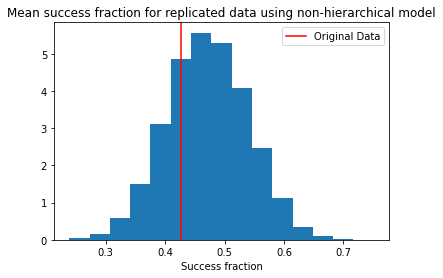

P-value:
0.7369


In [7]:
#plot test statistic histogram for mean test statistics

#plot histogram + title + axis
plt.hist(rep_t_stats["mean"], density = True, bins = 15)
plt.xlabel("Success fraction")
plt.title("Mean success fraction for replicated data using non-hierarchical model")

#Line for observed mean
plt.axvline(ob_t_stats["mean"], color = 'red', label = 'Original Data')
plt.legend()
plt.show()

print("P-value:")
print(np.mean(rep_t_stats["mean"] > ob_t_stats["mean"]))

### Variance

The p-value for the variance of success fraction is around 0.01 which is very low. The model thus not adequatly capture the variance in success fraction that the observed data has. This is evidence against that the non-hierarchical model would explain the observed data. The observed data appears to have a lot of variance around success fraction, which expectedly, is not the case for the non-hierarchical model since all trails have the same underlying successrate.

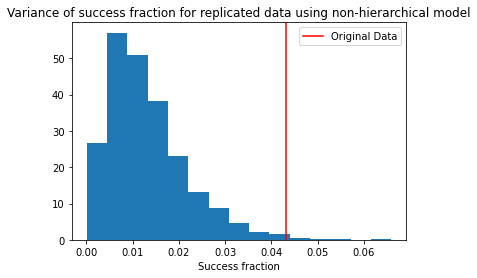

P-value:
0.0062


In [8]:
#plot test statistic histogram for variance test statistics

#plot histogram + title + axis
plt.hist(rep_t_stats["var"], density = True, bins = 15)
plt.xlabel("Success fraction")
plt.title("Variance of success fraction for replicated data using non-hierarchical model")

#Line for observed variance
plt.axvline(ob_t_stats["var"], color = 'red', label = 'Original Data')
plt.legend()
plt.show()

print("P-value:")
print(np.mean(rep_t_stats["var"] > ob_t_stats["var"]))

### Minimum + Maximum + Range

The p-value for both minimum and range is below/above the guideline of 0.05/0.95. The non-hierarchical model does not adequatly explain the minimum successfraction of 0 that we saw in the observed dataset. This to expected since obtaining a successfraction of 0, with group sizes of above 10 is very unlikely given the else farly high success fractions in the dataset which is seen in the posterior distribution for successrate. The model however does in fact explain the maximum successrate very well. The implications of the minimum successrate is seen in the range p value with is very low.

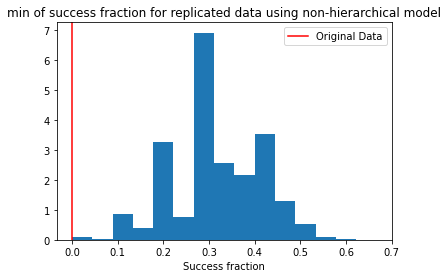

P-value:
0.9961


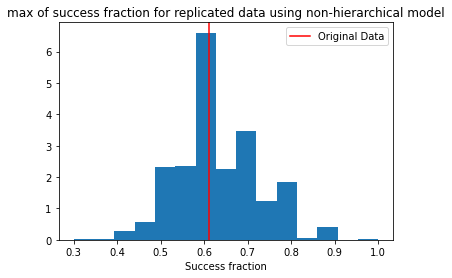

P-value:
0.4668


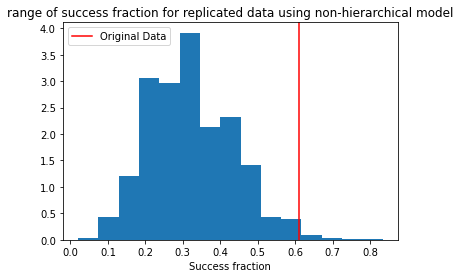

P-value:
0.0082


In [9]:
#plot test statistic histogram for Minimum + Maximum + Range test statistics

test_types = ["min", "max", "range"]

for test in test_types:

    #plot histogram + title + axis
    plt.hist(rep_t_stats[test], density = True, bins = 15)
    plt.xlabel("Success fraction")
    plt.title(f"{test} of success fraction for replicated data using non-hierarchical model")

    #Line for observed test_statistic
    plt.axvline(ob_t_stats[test], color = 'red', label = 'Original Data')
    plt.legend()
    plt.show()

    print("P-value:")
    print(np.mean(rep_t_stats[test] > ob_t_stats[test]))

# Summary

The posterior predictive check reviels that the non-hierarcical model isn't a very good at explaining the observed control data set. While the mean and max success fraction is captured by the model, the variance within the successfraction and the minimum successfraction isn't properly captures. In the observed data, the minimum successfraction was 0, and the variance was around 0.04 while for the replicated data generated using the non-hierarcical model has it's mode in minimum successfraction around 0.3 and mode in variance around 0.01.

In conclusion, the control group dataset isn't likely generated from a processes where the probability of improvement is the same for each trail.